In [82]:
import pandas as pd
from ktest.tester import Ktest
import matplotlib.pyplot as plt
import numpy as np
import torch 
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from utils_reversion import *

In [83]:
colors_condition = {'0H':'xkcd:bright blue','24H':'xkcd:leaf green','48HDIFF':'crimson','48HREV':'xkcd:pale purple',
         '48HREV_1':'xkcd:aqua green',
          '48HREV_2':'xkcd:light magenta'}

colors_batch = {'REV1':None, 'REV2':None, 'REV3':None, 'REV4':None, 
                'REV5':None, 'REV6':None, 'REV7':None, 'REV8':'xkcd:aqua blue'}

cmaps = {
    '0H':LinearSegmentedColormap.from_list('0H', colors=['xkcd:baby blue','xkcd:bright blue'], N=20),
    '24H':LinearSegmentedColormap.from_list('24H', colors=['xkcd:seafoam','xkcd:leaf green'], N=20),
    '48HDIFF':LinearSegmentedColormap.from_list('48HDIFF', colors=['xkcd:coral','xkcd:crimson'], N=20),
    '48HREV':LinearSegmentedColormap.from_list('48HDIFF', colors=['xkcd:pale purple','xkcd:vibrant purple'], N=20),
    '48HREV_1':LinearSegmentedColormap.from_list('48HDIFF', colors=['xkcd:aqua green','xkcd:bright teal'], N=20),
    '48HREV_2':LinearSegmentedColormap.from_list('48HDIFF', colors=['xkcd:pale mauve','xkcd:light magenta'], N=20),
}


In [164]:
path = "/home/data/reversion/"
data = pd.read_csv(f'{path}RTqPCR_reversion_logcentered.csv',index_col=0)
data = pd.read_csv(f'{path}RTqPCR_reversion_logx.csv',index_col=0)
meta = get_meta_from_df(data)

kt = Ktest(data=data,
          metadata=meta.copy(),
          condition='condition',
          samples= 'all' # needed now to initialize the kernel bandwidth with all the data 
          )

sl = kt.get_samples_list(samples='all')


- Set test data info (24H,0H from condition)
- Set test data info (48HDIFF,0H from condition)
- Set test data info (48HDIFF,24H from condition)
- Set test data info (48HREV,0H from condition)
- Set test data info (48HREV,24H from condition)
- Set test data info (48HREV,48HDIFF from condition)


/home/anthony/miniconda3/envs/kfda/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


['48HREV', '48HDIFF']

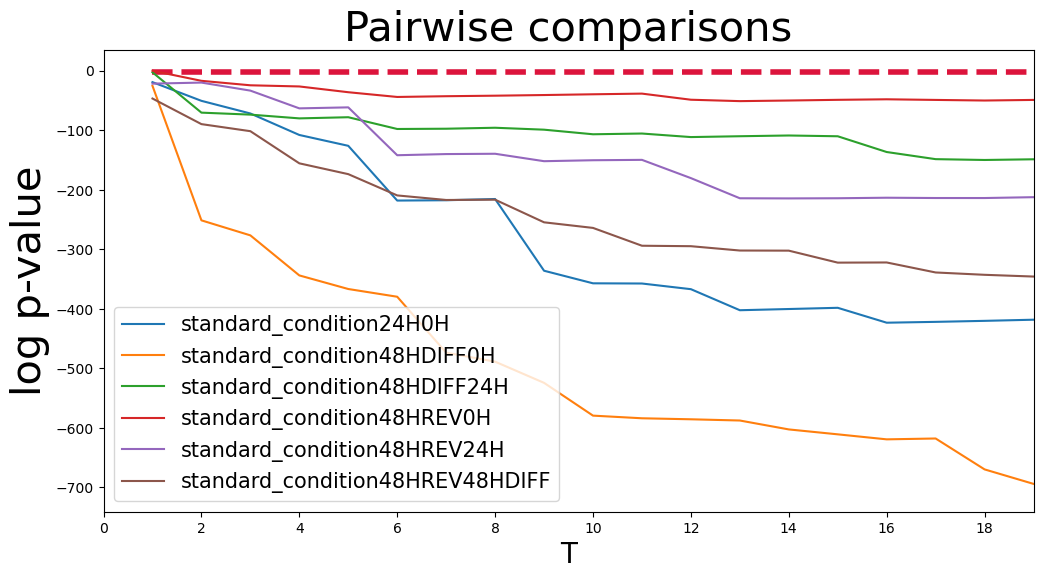

In [85]:

sl = kt.get_samples_list(samples='all')

comparaisons = []
for i,ci in enumerate(sl):
    for j,cj in enumerate(sl):
        if i>j: 
            comparaisons += [[ci,cj]]
comparaisons

for comparaison in comparaisons:
    kt.set_test_data_info(samples=comparaison,verbose=1)
    kt.multivariate_test()
    
kt.df_kfdat.columns = [f"{s1} vs {s2}" for s1,s2 in comparaisons]
fig,ax = kt.plot_several_pvalues(log=True,t=20)
ax.set_xlabel('T',fontsize=20)
ax.set_title('Pairwise comparisons',fontsize=30)
leg = ax.legend(fontsize=15)
for text in leg.texts:
    text._text = text._text.replace('standard_datacondition','')

comparaisons


pop48,condition48 = split_48HREV(kt,comparaison,t=10,nobs=23,orientation='>',verbose=0)
pop48
comparaison

# Test batch effect

torch.Size([7, 8])
3.185277649613214e-78


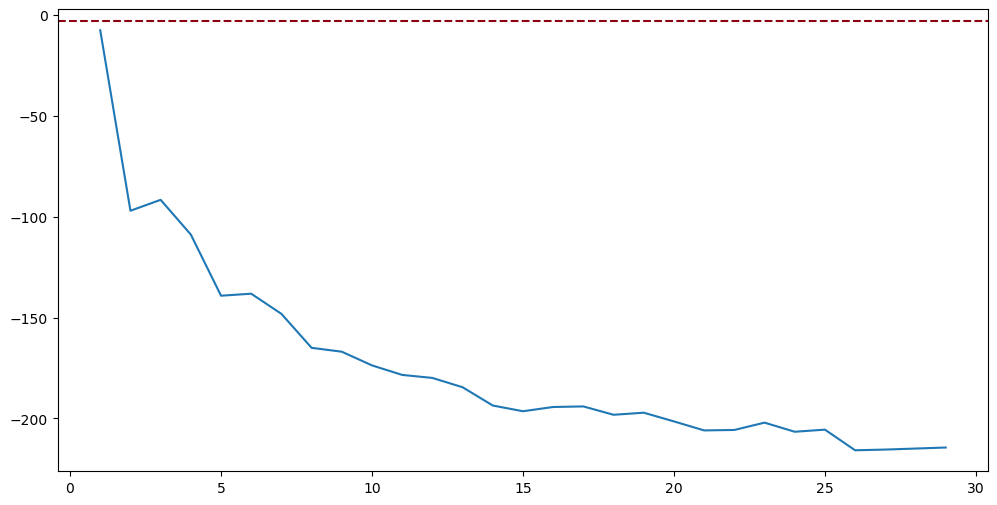

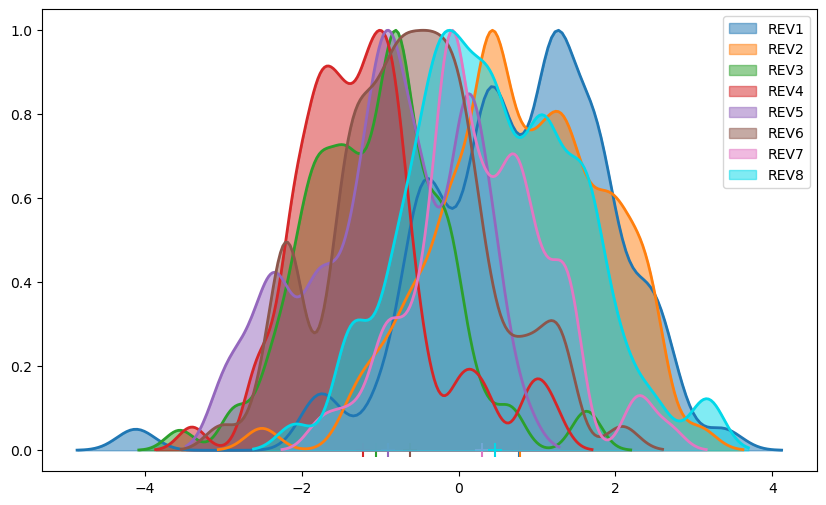

In [165]:

Lbatch = torch.tensor([[1,-1,0,0,0,0,0,0],
                  [0,1,-1,0,0,0,0,0],
                  [0,0,1,-1,0,0,0,0],
                  [0,0,0,1,-1,0,0,0],
                  [0,0,0,0,1,-1,0,0],
                  [0,0,0,0,0,1,-1,0],
                  [0,0,0,0,0,0,1,-1]],dtype=torch.float64) 
print(Lbatch.shape)
kt = Ktest(data=data,
          metadata=meta.copy(),
          condition='condition',
          samples= 'all' # needed now to initialize the kernel bandwidth with all the data 
          )

design_cols = ['batch']
comparison_name = 'batch_effect'
kt.set_design(design_cols=design_cols)
kt._diagonalize_residual_covariance()
kt.set_hypothesis(Lbatch,comparison_name,Tmax=30)
kt.compute_kernel_Hotelling_Lawley_test_statistic(hypothesis_name=comparison_name)
pvals = kt.hypotheses[comparison_name]['p-value']
print(pvals[10])
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(range(1,30),np.log(pvals))
ax.axhline(np.log(.05),color='xkcd:crimson',ls='--')
fig,ax = plt.subplots(figsize=(10,6))

kt.compute_proj_on_discriminant_directions(T=10,hypothesis_name=comparison_name)
proj = kt.df_proj_residuals[comparison_name]
for sample,color in colors_batch.items(): 
# for sample,color in colors_condition.items(): 
    proji = torch.tensor(proj.loc[kt.obs['batch']==sample][0].to_numpy(),dtype=torch.float64) 
#     proji = torch.tensor(proj.loc[kt.obs['condition']==sample][0].to_numpy(),dtype=torch.float64) 
    custom_histogram(proji,color=color,fig=fig,ax=ax,label=sample,)
ax.legend()
fig.savefig(f'/home/figures/reversion/RTqPCR_batch_effect_discriminant.pdf',bbox_inches='tight')
        

### Correct batch effect to test global condition


{'0H': 173, '24H': 173, '48HDIFF': 168, '48HREV': 171, 'ntot': 685}
torch.Size([3, 12])
t=10, pvalue= 0.0


/tmp/ipykernel_3792/31459051.py:25: RuntimeWarning: divide by zero encountered in log
  ax.plot(range(1,30),np.log(pvals))


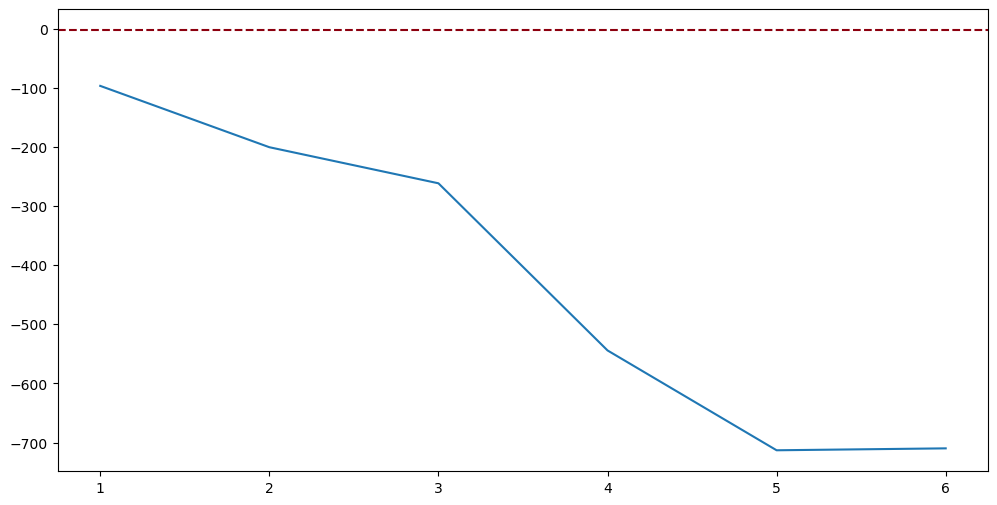

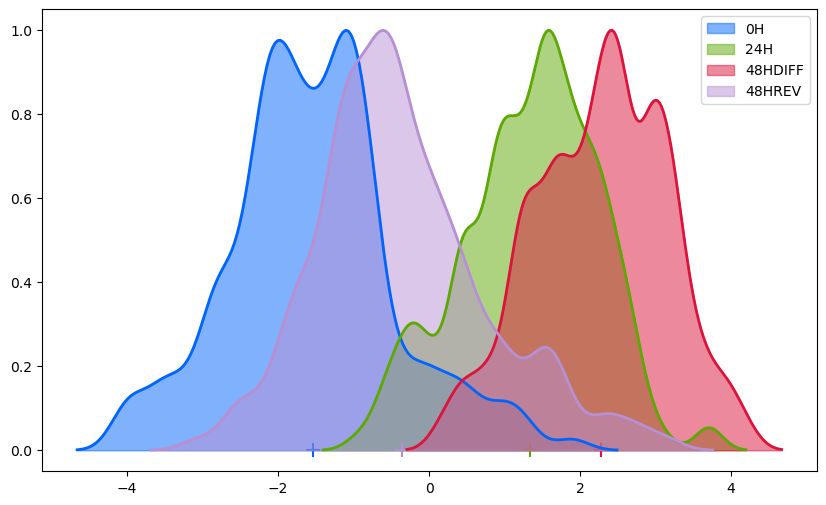

In [160]:
ns = kt.get_nobs(samples='all')
print(ns)
ps = {sample:n/ns['ntot'] for sample,n in ns.items() if sample !='ntot'}
L1vsall = torch.tensor([[1-ps['0H'],-ps['24H'],-ps['48HDIFF'],-ps['48HREV'],0,0,0,0,0,0,0,0], 
                  [-ps['0H'],1-ps['24H'],-ps['48HDIFF'],-ps['48HREV'],0,0,0,0,0,0,0,0], 
                  [-ps['0H'],-ps['24H'],1-ps['48HDIFF'],-ps['48HREV'],0,0,0,0,0,0,0,0], 
                 ],dtype=torch.float64) 

print(L1vsall.shape)
kt = Ktest(data=data,
          metadata=meta.copy(),
          condition='condition',
          samples= 'all' # needed now to initialize the kernel bandwidth with all the data 
          )

design_cols = ['condition','batch']
comparison_name = 'condition_effect'
kt.set_design(design_cols=design_cols)
kt._diagonalize_residual_covariance()
kt.set_hypothesis(L1vsall,comparison_name,Tmax=30)
kt.compute_kernel_Hotelling_Lawley_test_statistic(hypothesis_name=comparison_name)
pvals = kt.hypotheses[comparison_name]['p-value']
print('t=10, pvalue=',pvals[10])
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(range(1,30),np.log(pvals))
ax.axhline(np.log(.05),color='xkcd:crimson',ls='--')
fig,ax = plt.subplots(figsize=(10,6))

kt.compute_proj_on_discriminant_directions(T=10,hypothesis_name=comparison_name)
proj = kt.df_proj_residuals[comparison_name]
for sample,color in colors_condition.items(): 
    proji = torch.tensor(proj.loc[kt.obs['condition']==sample][0].to_numpy(),dtype=torch.float64) 
    custom_histogram(proji,color=color,fig=fig,ax=ax,label=sample,)
ax.legend()
fig.savefig(f'/home/figres/reversion/RTqPCR_condition_discriminant.pdf',bbox_inches='tight')
  

In [129]:
import torch 
import scipy.stats as st

L = torch.tensor([[1,-1,0,0,0,0,0,0,0,0]],dtype=torch.float64)
kt = Ktest(data=data,
          metadata=meta.copy(),
          condition='condition',
          samples= 'all' # needed now to initialize the kernel bandwidth with all the data 
          )

pvals_list = {}
for comparaison in comparaisons:
    comparison_name = "_".join(comparaison)
    kt.set_test_data_info(samples=comparaison,verbose=0)
    data_comparison = kt.get_data(in_dict=False,dataframe=True)
    meta_comparison = kt.get_metadata()
    meta_comparison['condition'] = meta_comparison['condition'].astype('str').astype('category')
    kt_comparison = Ktest(data=data_comparison,
              metadata=meta_comparison.copy(),
              condition='condition',
              samples= 'all' # needed now to initialize the kernel bandwidth with all the data 
              )
    kt_comparison.multivariate_test()
    design_cols = ['condition','batch']
    kt_comparison.set_design(design_cols=design_cols)
    kt_comparison.set_hypothesis(L,comparison_name,Tmax=30)
    kt_comparison._diagonalize_residual_covariance()
    kt_comparison.compute_kernel_Hotelling_Lawley_test_statistic(hypothesis_name=comparison_name)
    pvals = kt_comparison.hypotheses[comparison_name]['p-value']
    print(comparison_name,pvals[10])


24H_0H 1.8939038252124991e-165
48HDIFF_0H 5.5170473280518006e-266
48HDIFF_24H 2.2917744766203555e-55
48HREV_0H 4.5562038468883446e-23
48HREV_24H 1.0132280980984128e-68
48HREV_48HDIFF 4.9677338247621045e-124


- Set test data info (48HDIFF,48HREV from condition)
19


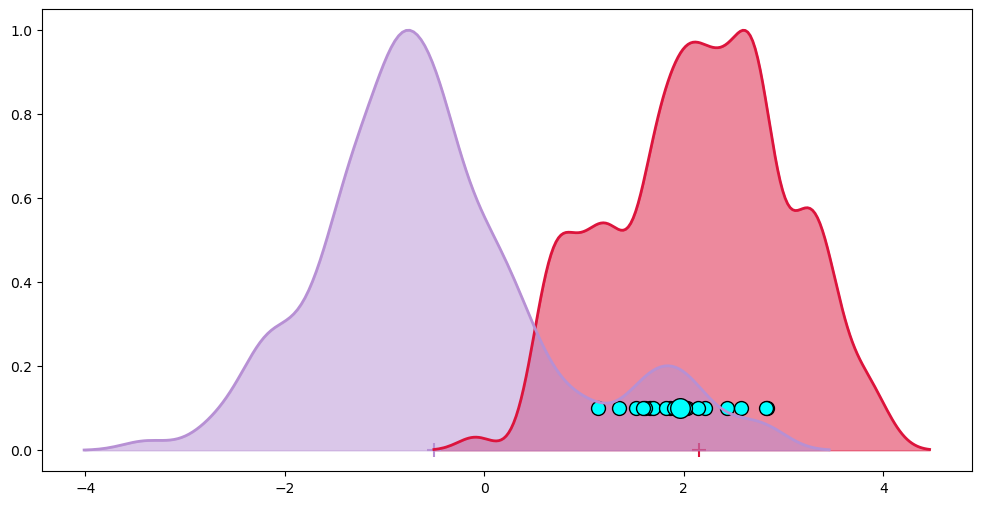

In [106]:

for comparaison in [['48HDIFF','48HREV']]:
    comparison_name = "_".join(comparaison)
    kt.set_test_data_info(samples=comparaison,verbose=1)
    data_comparison = kt.get_data(in_dict=False,dataframe=True)
    meta_comparison = kt.get_metadata()
    meta_comparison['condition'] = meta_comparison['condition'].astype('str').astype('category')
    kt_comparison = Ktest(data=data_comparison,
              metadata=meta_comparison.copy(),
              condition='condition',
              samples= 'all' # needed now to initialize the kernel bandwidth with all the data 
              )
    L = torch.tensor([[1,-1,0,0,0,0,0,0,0,0]],dtype=torch.float64)
    design_cols = ['condition','batch']
    kt_comparison.set_design(design_cols=design_cols)
    kt_comparison.set_hypothesis(L,comparison_name,Tmax=30)
    kt_comparison._diagonalize_residual_covariance()
    kt_comparison.compute_kernel_Hotelling_Lawley_test_statistic(hypothesis_name=comparison_name)
    pvals = kt_comparison.hypotheses[comparison_name]['p-value']

    for t in [10]:
        kt_comparison.compute_proj_on_discriminant_directions(T=t,hypothesis_name=comparison_name)
        proj = -kt_comparison.df_proj_residuals[comparison_name]
        fig,ax = plt.subplots(figsize=(12,6))
        for sample in comparaison: 
            color = colors_condition[sample]
            proji = torch.tensor(proj.loc[kt.obs['condition']==sample][0].to_numpy(),dtype=torch.float64) 
            custom_histogram(proji,color=color,fig=fig,ax=ax,label=sample,)
            if sample == '48HREV':
                proj48 = proj.loc[kt.obs['condition']==sample][0]
                pop48_cbfs = proj48.loc[proj48>1].index
                proj48HREV1_cbfs = torch.tensor(proj48.loc[proj48>1].to_numpy(),dtype=torch.float64)
                print(len(proj48HREV1_cbfs))
                ax.scatter(proj48HREV1_cbfs,[0.1]*len(proj48HREV1_cbfs),s=100,color='cyan',edgecolor='black')
                ax.scatter(proj48HREV1_cbfs.mean(),0.1,s=200,color='cyan',edgecolor='black')
        

torch.Size([1, 10])
19
19
19


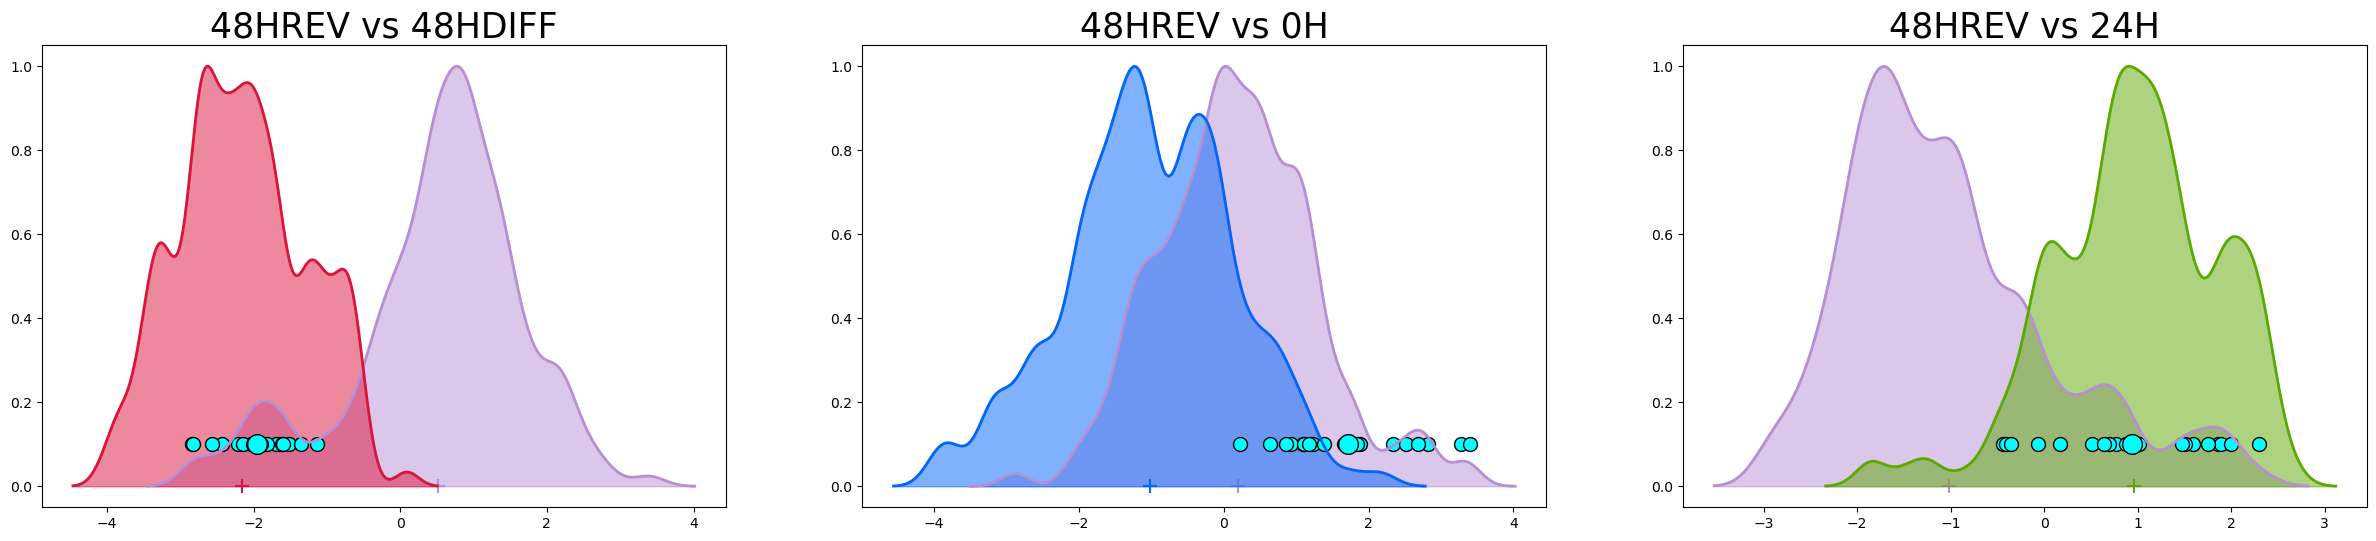

In [133]:
L = torch.tensor([[1,-1,0,0,0,0,0,0,0,0]],dtype=torch.float64)
print(L.shape)

fig,axes = plt.subplots(ncols=3,figsize=(30,6))
for sample,ax in zip(['48HDIFF','0H','24H'],axes):
    ax.set_title(f'48HREV vs {sample}',fontsize=25)
    comparison_name = "_".join(comparaison)
    comparaison = ['48HREV',sample]
    kt.set_test_data_info(condition='condition',samples=comparaison)
    data_comparison = kt.get_data(in_dict=False,dataframe=True)
    meta_comparison = kt.get_metadata()
    meta_comparison['condition'] = meta_comparison['condition'].astype('str').astype('category')
    kt_comparison = Ktest(data=data_comparison,
              metadata=meta_comparison.copy(),
              condition='condition',
              samples= 'all' # needed now to initialize the kernel bandwidth with all the data 
              )
    design_cols = ['condition','batch']
    kt_comparison.set_design(design_cols=design_cols)
    kt_comparison.set_hypothesis(L,comparison_name,Tmax=30)
    kt_comparison._diagonalize_residual_covariance()
    kt_comparison.compute_kernel_Hotelling_Lawley_test_statistic(hypothesis_name=comparison_name)
    pvals = kt_comparison.hypotheses[comparison_name]['p-value']

    for t in [10]:
        kt_comparison.compute_proj_on_discriminant_directions(T=t,hypothesis_name=comparison_name)
        proj = kt_comparison.df_proj_residuals[comparison_name]
        for sample in comparaison: 
            color = colors_condition[sample]
            proji = torch.tensor(proj.loc[kt.obs['condition']==sample][0].to_numpy(),dtype=torch.float64) 
            custom_histogram(proji,color=color,fig=fig,ax=ax,label=sample,kde_bw=.18)
        proj48 = proj.loc[kt.obs['condition']=='48HREV'][0]
        proj48HREV1_cbfs = torch.tensor(proj48.loc[pop48_cbfs].to_numpy(),dtype=torch.float64)
        print(len(proj48HREV1_cbfs))
        ax.scatter(proj48HREV1_cbfs,[0.1]*len(proj48HREV1_cbfs),s=100,color='cyan',edgecolor='black')
        ax.scatter(proj48HREV1_cbfs.mean(),0.1,s=200,color='cyan',edgecolor='black')
fig.savefig(f'/home/figures/reversion/RTqPCR_pairwise_discriminant.pdf',bbox_inches='tight')
 

(0.0, 352.3517097994715)
['0H', '48HREV', '24H', '48HDIFF']
(0.0, 79.41060074984246)
['24H', '48HDIFF', '48HREV-1', '0H', '48HREV-2']


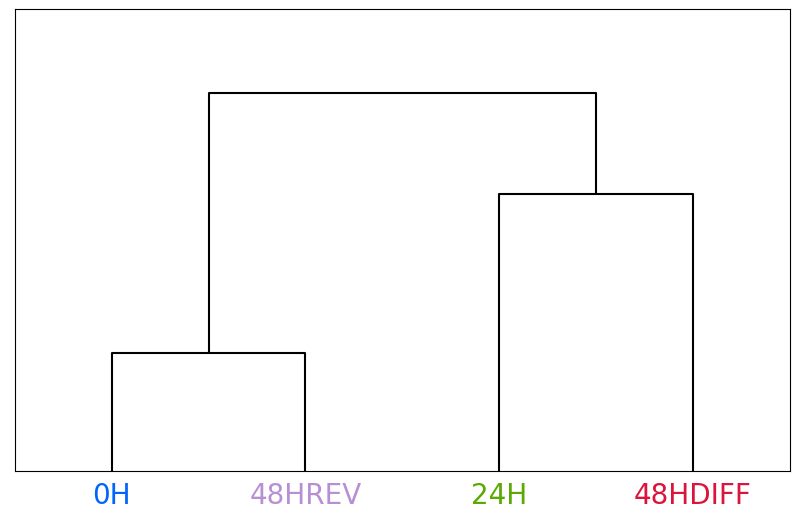

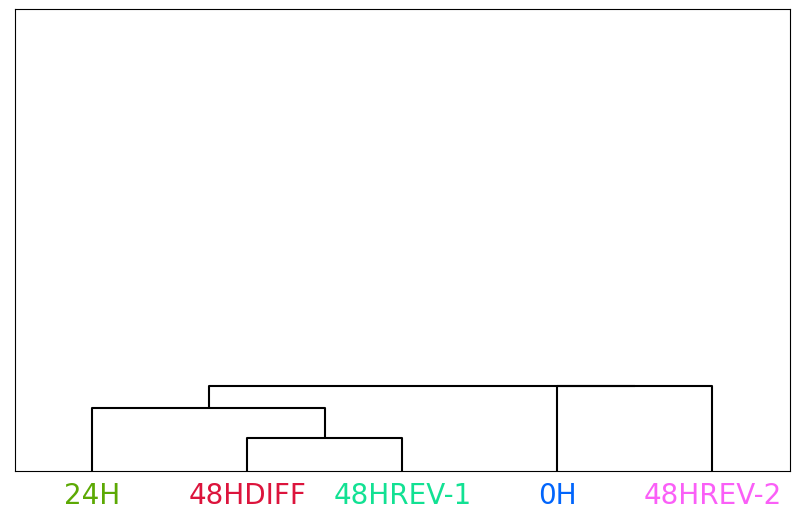

In [134]:
t=10
new_condition = 'condition_48'

kt.split_sample(pop=pop48_cbfs,
                sample='48HREV',
                new_condition=new_condition,
                new_samples=['48HREV_1','48HREV_2'],
                condition='condition')
kt.set_test_data_info(condition=new_condition,samples=['48HREV_1','0H'])
for condition in ['condition',new_condition]:
    fig,ax = kt.plot_custom_dendrogram(t=t,samples='all',condition=condition)
    for i,c in enumerate(ax.__dict__['_children']):
        c.set_edgecolors('black')
    [sample.set_color(colors_condition[sample._text]) for sample in ax.get_xticklabels()]
    print(ax.get_ylim())
    xticklabels =[sample._text.replace('_','-') for sample in ax.get_xticklabels()]
    print(xticklabels)
    ax.set_xticklabels(xticklabels,fontsize=20,rotation=0)
    ax.set_yticks([])
    ax.set_ylim(0,410)
    fig.savefig(f'/home/figures/reversion/RTqPCR_dendrogram_{condition}.pdf',bbox_inches='tight')
 
    

torch.Size([7, 8])
{'0H': 173, '24H': 173, '48HDIFF': 168, '48HREV': 171, 'ntot': 685}
torch.Size([3, 12])
t=10, pvalue= 0.0
{'0H': 173, '24H': 173, '48HDIFF': 168, '48HREV_1': 19, '48HREV_2': 152, 'ntot': 685}
torch.Size([4, 13])
t=10, pvalue= 0.0


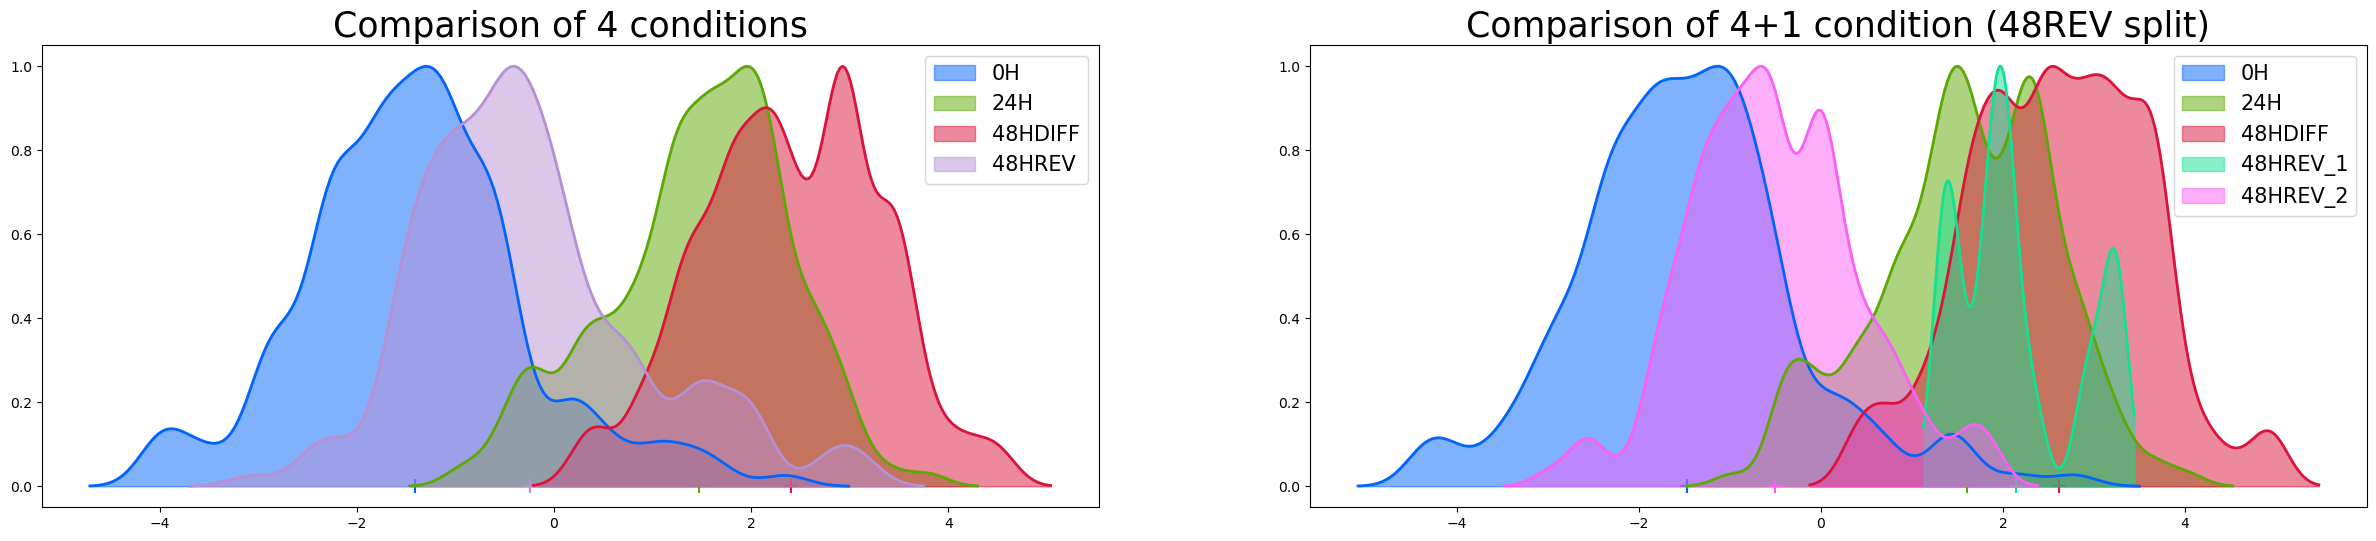

In [173]:

import torch 
import scipy.stats as st
Lbatch = torch.tensor([[1,-1,0,0,0,0,0,0],
                  [0,1,-1,0,0,0,0,0],
                  [0,0,1,-1,0,0,0,0],
                  [0,0,0,1,-1,0,0,0],
                  [0,0,0,0,1,-1,0,0],
                  [0,0,0,0,0,1,-1,0],
                  [0,0,0,0,0,0,1,-1]],dtype=torch.float64) 
print(Lbatch.shape)
kt = Ktest(data=data,
          metadata=meta.copy(),
          condition='condition',
          samples= 'all' # needed now to initialize the kernel bandwidth with all the data 
          )

design_cols = ['batch']
comparison_name = 'batch_effect'
kt = Ktest(data=data,
          metadata=meta.copy(),
          condition='condition',
          samples= 'all' # needed now to initialize the kernel bandwidth with all the data 
          )
kt.split_sample(pop=pop48_cbfs,
                sample='48HREV',
                new_condition=new_condition,
                new_samples=['48HREV_1','48HREV_2'],
                condition='condition')

# conditions = ['batch','condition',new_condition]
conditions = ['condition',new_condition]
fig,axes = plt.subplots(ncols=len(conditions),figsize=(30,6))

for condition,ax in zip(conditions,axes):
    if condition == 'batch':
        ax.set_title('Batches',fontsize=25)
        design_cols = ['batch']
        comparison_name = 'batch_effect'
        L1vsall = Lbatch = torch.tensor([[1,-1,0,0,0,0,0,0],
                  [0,1,-1,0,0,0,0,0],
                  [0,0,1,-1,0,0,0,0],
                  [0,0,0,1,-1,0,0,0],
                  [0,0,0,0,1,-1,0,0],
                  [0,0,0,0,0,1,-1,0],
                  [0,0,0,0,0,0,1,-1]],dtype=torch.float64) 
        comparison_name = 'test_batch'
        colors = colors_batch
    else:
        kt.set_test_data_info(condition=condition,samples=['48HDIFF','0H'])
        ns = kt.get_nobs(samples='all')
        print(ns)
        ps = {sample:n/ns['ntot'] for sample,n in ns.items() if sample !='ntot'}
        if condition == 'condition':
            ax.set_title('Comparison of 4 conditions',fontsize=25)
            L1vsall = torch.tensor([[1-ps['0H'],-ps['24H'],-ps['48HDIFF'],-ps['48HREV'],0,0,0,0,0,0,0,0], 
                      [-ps['0H'],1-ps['24H'],-ps['48HDIFF'],-ps['48HREV'],0,0,0,0,0,0,0,0], 
                      [-ps['0H'],-ps['24H'],1-ps['48HDIFF'],-ps['48HREV'],0,0,0,0,0,0,0,0], 
                     ],dtype=torch.float64) 
        else:
            ax.set_title('Comparison of 4+1 condition (48REV split)',fontsize=25)
            L1vsall = torch.tensor([[1-ps['0H'],-ps['24H'],-ps['48HDIFF'],-ps['48HREV_1'],-ps['48HREV_2'],0,0,0,0,0,0,0,0], 
                      [-ps['0H'],1-ps['24H'],-ps['48HDIFF'],-ps['48HREV_1'],-ps['48HREV_2'],0,0,0,0,0,0,0,0], 
                      [-ps['0H'],-ps['24H'],1-ps['48HDIFF'],-ps['48HREV_1'],-ps['48HREV_2'],0,0,0,0,0,0,0,0], 
                      [-ps['0H'],-ps['24H'],-ps['48HDIFF'],1-ps['48HREV_1'],-ps['48HREV_2'],0,0,0,0,0,0,0,0], 
                     ],dtype=torch.float64) 
        print(L1vsall.shape)
        design_cols = [condition,'batch']
        comparison_name = f'test_{condition}'
        colors = colors_condition
        
        
    kt.set_design(design_cols=design_cols)
    kt._diagonalize_residual_covariance()
    kt.set_hypothesis(L1vsall,comparison_name,Tmax=30)
    kt.compute_kernel_Hotelling_Lawley_test_statistic(hypothesis_name=comparison_name)
    pvals = kt.hypotheses[comparison_name]['p-value']
    print('t=10, pvalue=',pvals[10])
    kt.compute_proj_on_discriminant_directions(T=10,hypothesis_name=comparison_name)
    proj = kt.df_proj_residuals[comparison_name]
    for sample,color in colors.items(): 
        proji = torch.tensor(proj.loc[kt.obs[condition]==sample][0].to_numpy(),dtype=torch.float64) 
        custom_histogram(proji,color=color,fig=fig,ax=ax,label=sample,)
    ax.legend(fontsize=15)
fig.savefig(f'/home/figures/reversion/RTqPCR_{len(conditions)}multivariates.pdf',bbox_inches='tight')
  

In [174]:
import torch 
import scipy.stats as st

L = torch.tensor([[1,-1,0,0,0,0,0,0,0,0]],dtype=torch.float64)
kt = Ktest(data=data,
          metadata=meta.copy(),
          condition='condition',
          samples= 'all' # needed now to initialize the kernel bandwidth with all the data 
          )

kt.split_sample(pop=pop48_cbfs,
                sample='48HREV',
                new_condition=new_condition,
                new_samples=['48HREV_1','48HREV_2'],
                condition='condition')
kt.set_test_data_info(condition=new_condition,samples=['48HREV_1','0H'])
condition = 'condition_48'
sl = kt.get_samples_list(samples='all')
print(sl)
comparaisons = []
for i,ci in enumerate(sl):
    for j,cj in enumerate(sl):
        if i>j: 
            comparaisons += [[ci,cj]]
print(comparaisons)


for comparaison in comparaisons:
    comparison_name = "_".join(comparaison)
    kt.set_test_data_info(samples=comparaison,verbose=0)
    
    data_comparison = kt.get_data(in_dict=False,dataframe=True)
    meta_comparison = kt.get_metadata()
    meta_comparison['condition'] = meta_comparison['condition'].astype('str').astype('category')
    meta_comparison['condition_48'] = meta_comparison['condition_48'].astype('str').astype('category')
    kt_comparison = Ktest(data=data_comparison,
              metadata=meta_comparison.copy(),
              condition='condition',
              samples= 'all' # needed now to initialize the kernel bandwidth with all the data 
              )
    if '48HREV' in comparison_name:
        kt_comparison.split_sample(pop=pop48_cbfs,
                    sample='48HREV',
                    new_condition=new_condition,
                    new_samples=['48HREV_1','48HREV_2'],
                    condition='condition')
#         kt_comparison.set_test_data_info(condition=new_condition,samples=['48HREV_1','0H'])
        design_cols = ['condition_48','batch']
    else:
        design_cols = ['condition','batch']
    kt_comparison.set_design(design_cols=design_cols)
    kt_comparison.set_hypothesis(L,comparison_name,Tmax=30)
    kt_comparison._diagonalize_residual_covariance()
    kt_comparison.compute_kernel_Hotelling_Lawley_test_statistic(hypothesis_name=comparison_name)
    pvals = kt_comparison.hypotheses[comparison_name]['p-value']
    print(comparison_name,pvals[10])


['0H', '24H', '48HDIFF', '48HREV_1', '48HREV_2']
[['24H', '0H'], ['48HDIFF', '0H'], ['48HDIFF', '24H'], ['48HREV_1', '0H'], ['48HREV_1', '24H'], ['48HREV_1', '48HDIFF'], ['48HREV_2', '0H'], ['48HREV_2', '24H'], ['48HREV_2', '48HDIFF'], ['48HREV_2', '48HREV_1']]
24H_0H 1.8939038252124991e-165
48HDIFF_0H 5.5170473280518006e-266
48HDIFF_24H 2.2917744766203555e-55
48HREV_1_0H 2.285686237915397e-25
48HREV_1_24H 9.124346492807124e-08
48HREV_1_48HDIFF 4.738281201058854e-05
48HREV_2_0H 4.4887752023829295e-17
48HREV_2_24H 2.7849368960421e-99
48HREV_2_48HDIFF 1.775666339623904e-167
48HREV_2_48HREV_1 2.6891762315291235e-11


cluster 0 (20) : ACSL6,betaglobin,CTSA,GPT2,HYAL1,MAPK12,MFSD2B,MKNK2,NCOA4,PLAG1,RBM38,RFFL,RPL22L1,SLC25A37,SLC6A9,SLC9A3R2,SNX22,STX12,TBC1D7,TTYH2
cluster 1 (31) : ACSS1,ALAS1,AMDHD2,BCL11A,CREG1,CTCF,DCP1A,DCTD,DPP7,FAM208B,FNIP1.F1.R1,GLRX5,HSP90AA1,MTFR1,PIK3CG,PLS1,PLS3,PPP1R15B,REXO2,SERPINI1,SMPD1,SNX27,SQSTM1,SULT1E1,TADA2L,TNFRSF21,TPP1,UCK1,VDAC3,WDR91,XPNPEP1
cluster 2 (32) : AACS,ARHGEF2,BATF,BPI,CD151,CD44,CRIP2,CYP51A1,DHCR24,DHCR7,EGFR,EMB,FHL3,GSN,HMGCS1,HRAS1,HSD17B7,LCP1,LDHA,MID2,MVD,MYO1G,NSDHL,PDLIM7,PTPRC,RSFR,RUNX2,sca2,SCD,SQLE,STARD4,SULF2


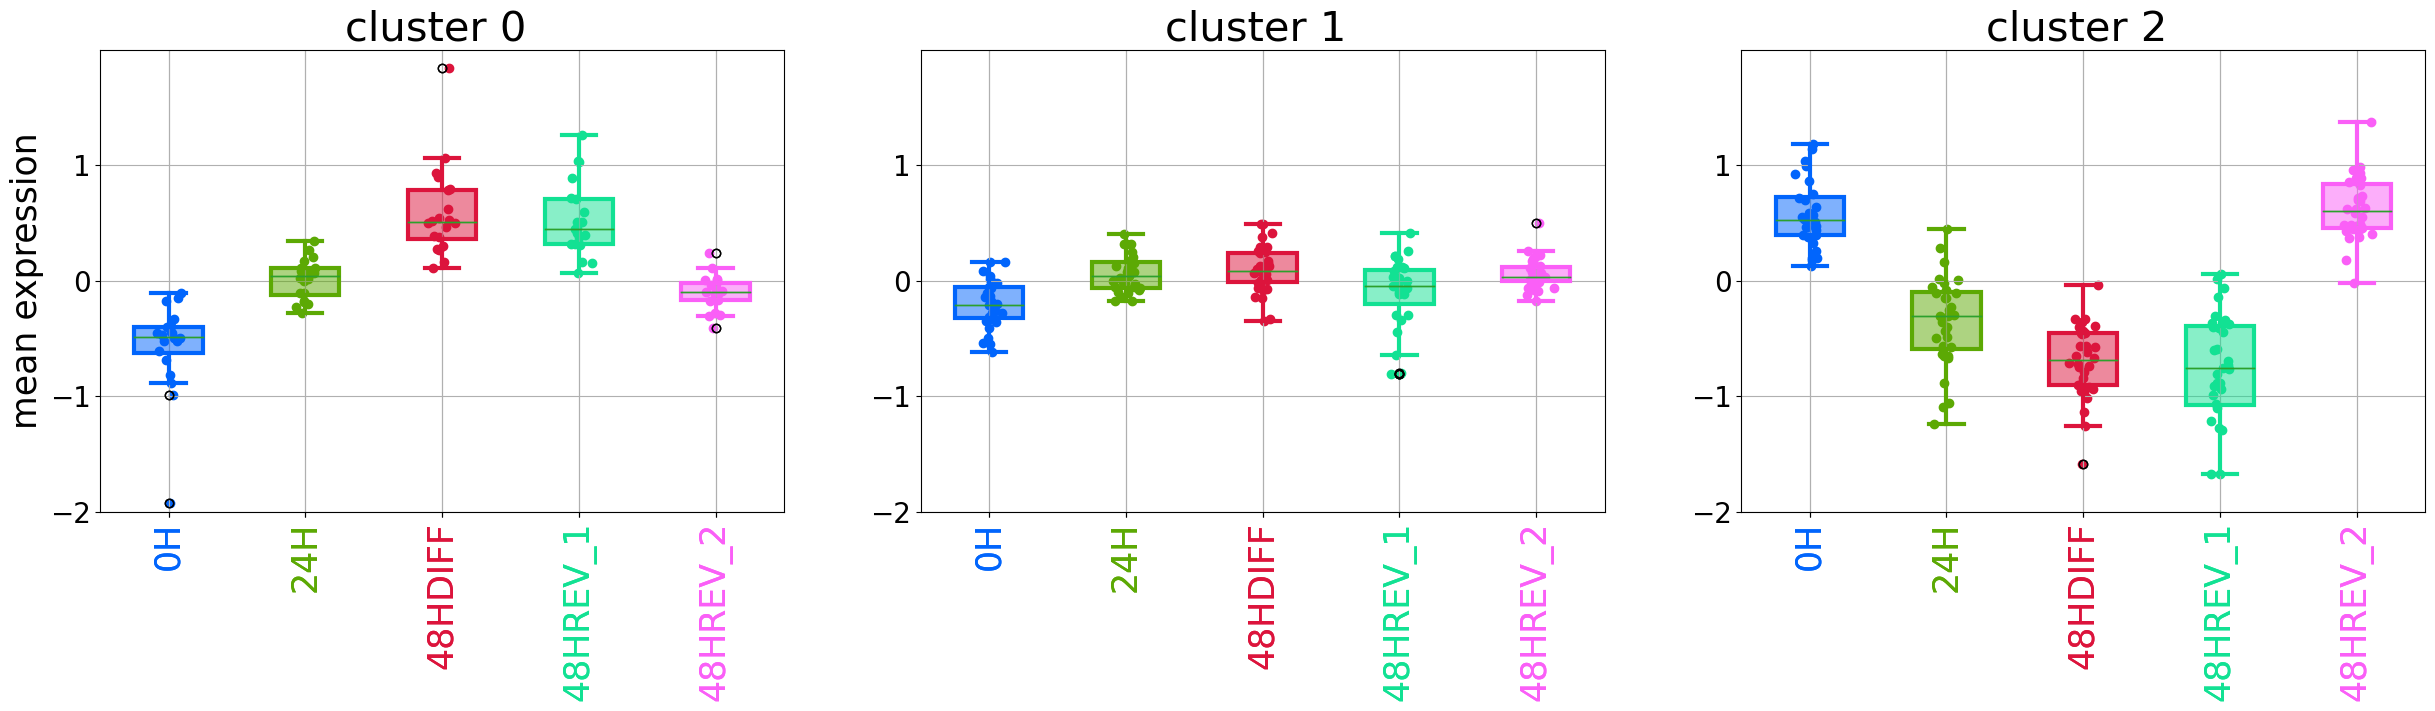

In [163]:
def split_dataframe_by_column(df,column,keep_columns=None):
    if keep_columns is None:
        keep_columns = df.columns
    dfs = {c:df[df[column]==c][keep_columns] for c in df[column].unique()}
    return(dfs)

path = "/home/data/reversion/"
data_cluster_genes = pd.read_csv(f'{path}RTqPCR_reversion_logcentered.csv',index_col=0)
meta = get_meta_from_df(data_cluster_genes)
kt = Ktest(data=data_cluster_genes,
          metadata=meta.copy(),
          condition='condition',
          samples= 'all' # needed now to initialize the kernel bandwidth with all the data 
          )
kt.split_sample(pop48_cbfs,'48HREV',new_condition='condition48',condition='condition')
for n_clusters in [3]:
    fig,axes = plt.subplots(ncols=n_clusters,figsize=(30,6))
    clusters,fig,axes = cluster_genes_from_condition(kt,condition='condition48',n_clusters=n_clusters,verbose=1,vert=True,
                                                     colors=colors_condition,fig=fig,axes=axes)
    for ax in axes:
        ax.set_title(ax.get_title().split(sep='(')[0],fontsize=30)
        ax.set_xticklabels([l._text for l in ax.get_xticklabels()],fontsize=25,rotation=90)
        [sample.set_color(colors_condition[sample._text]) for sample in ax.get_xticklabels()]
        ax.set_yticks([ -2+i for i in range(4)])
        ax.set_yticklabels([l._text for i,l in enumerate(ax.get_yticklabels()) ],fontsize=20)
    axes[0].set_ylabel('mean expression',fontsize=25)

    design_cols = ['condition','batch']
    kt.set_test_data_info(samples='all') # initialize a kernel on the basis of all data 
    kt.init_kernel(function='linear')
    kt.set_design(design_cols=design_cols)
    kt._diagonalize_residual_covariance()
    plt.show()
    fig.savefig(f'/home/figures/reversion/RTqPCR_{n_clusters}gene_clusters.pdf',bbox_inches='tight')

{'0H': 173, '24H': 173, '48HDIFF': 168, '48HREV': 171, 'ntot': 685}
torch.Size([3, 12])


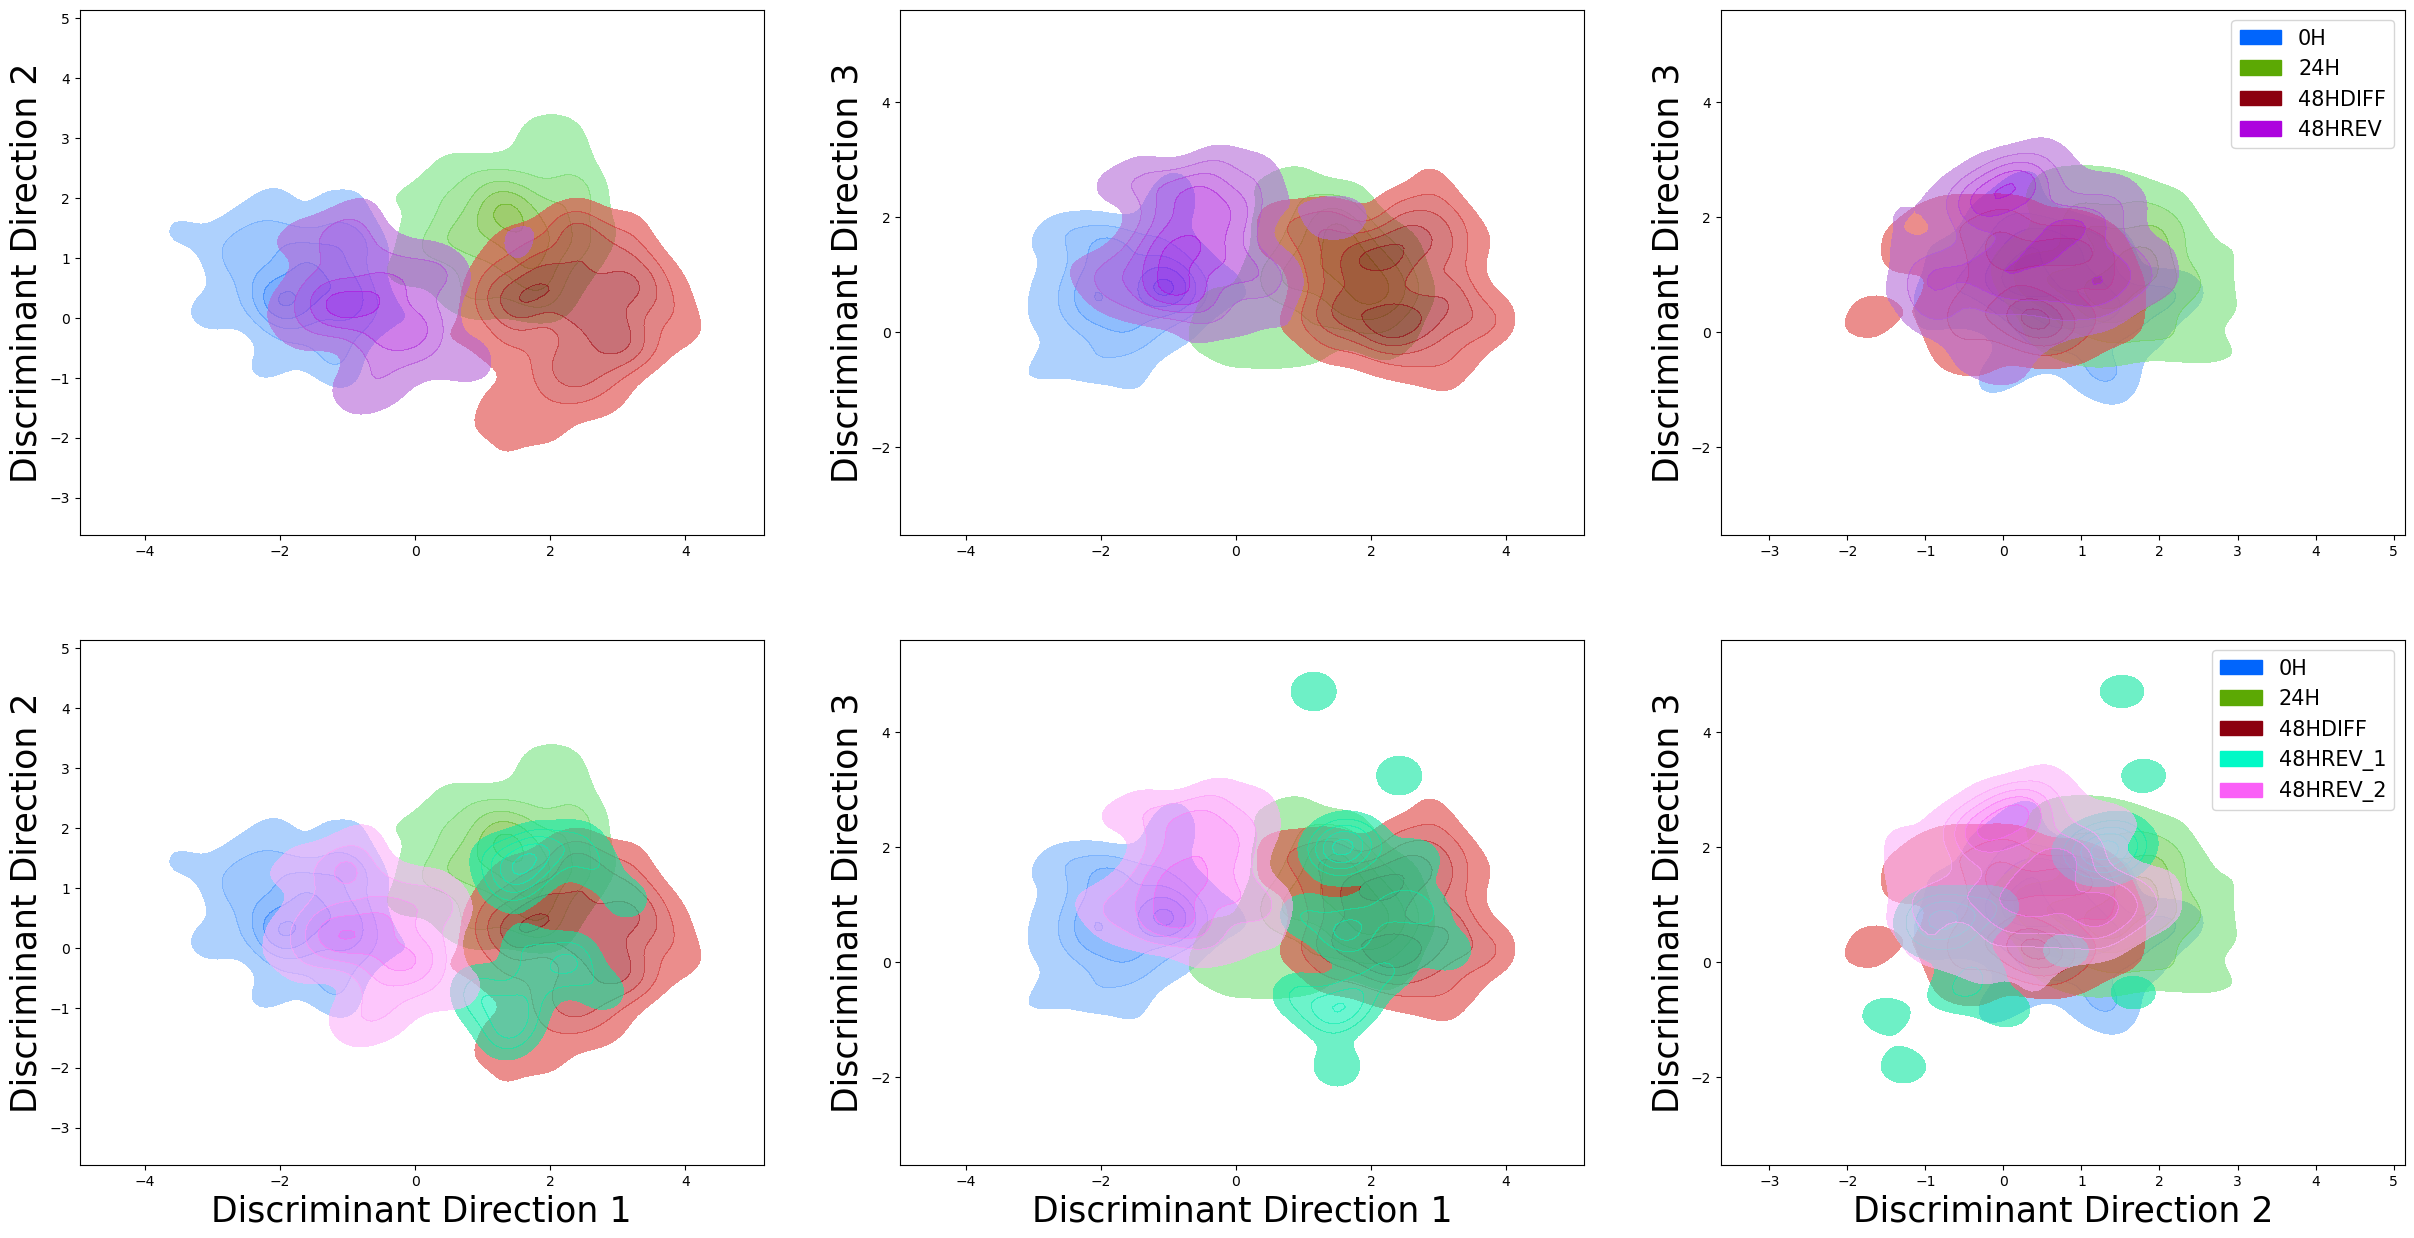

In [147]:



ns = kt.get_nobs(samples='all')
print(ns)
ps = {sample:n/ns['ntot'] for sample,n in ns.items() if sample !='ntot'}
L1vsall = torch.tensor([[1-ps['0H'],-ps['24H'],-ps['48HDIFF'],-ps['48HREV'],0,0,0,0,0,0,0,0], 
                  [-ps['0H'],1-ps['24H'],-ps['48HDIFF'],-ps['48HREV'],0,0,0,0,0,0,0,0], 
                  [-ps['0H'],-ps['24H'],1-ps['48HDIFF'],-ps['48HREV'],0,0,0,0,0,0,0,0], 
                 ],dtype=torch.float64) 

print(L1vsall.shape)
kt = Ktest(data=data,
          metadata=meta.copy(),
          condition='condition',
          samples= 'all' # needed now to initialize the kernel bandwidth with all the data 
          )
kt.split_sample(pop48_cbfs,'48HREV',new_condition='condition48',condition='condition')
design_cols = ['condition','batch']
comparison_name = 'condition_effect'
kt.set_design(design_cols=design_cols)
kt._diagonalize_residual_covariance()
kt.set_hypothesis(L1vsall,comparison_name,Tmax=30)
kt.compute_kernel_Hotelling_Lawley_test_statistic(hypothesis_name=comparison_name)
pvals = kt.hypotheses[comparison_name]['p-value']

embeddings,predictions,residuals = kt.compute_diagnostics()
for t in [10]:
    fig,axes= plt.subplots(ncols=3,nrows=2,figsize=(30,15))
    for col in 'condition','condition48':
        hn = comparison_name
        colors = colors_batch if 'batch' in hn else colors_condition
        kt.compute_proj_on_discriminant_directions(T=t,hypothesis_name=hn)
        hyp = kt.hypotheses[hn]
        proj = kt.df_proj_residuals[hn]
        axescol = axes[0,:] if col == 'condition' else axes[1,:]
        for sample,color in colors.items():
            for i,j,ax in zip([0,0,1],[1,2,2],axescol):
                if col != 'condition':
                    ax.set_xlabel(f'Discriminant Direction {i+1}',fontsize=25)
                ax.set_ylabel(f'Discriminant Direction {j+1}',fontsize=25)
                proji = torch.tensor(proj.loc[kt.obs[col]==sample][i].to_numpy(),dtype=torch.float64)
                projj = torch.tensor(proj.loc[kt.obs[col]==sample][j].to_numpy(),dtype=torch.float64) 
                
                sns.kdeplot(data=proji.numpy(), data2=projj.numpy(),
                                shade=True,
                                cmap=cmaps[sample],
                                ax=ax,
                                shade_lowest=False,
                               n_levels=5,
    #                            cut=0,
                                bw=.3,
                               alpha=.6,
                            legend=True,
                            label=sample
                                )
                if i==1 and j == 2:
                    ax.legend(fontsize=15)
    fig.savefig(f'/home/figures/reversion/RTqPCR_2D_discriminant_{condition}.pdf',bbox_inches='tight')
    plt.show()

In [ ]:
import umap
dfa = kt.get_dataframe_of_all_data()
reducer = umap.UMAP(n_neighbors=15,n_epochs=2000)
z = reducer.fit_transform(dfa)

dfa['umap1']  = z[:,0]
dfa['umap2']  = z[:,1]

dfa['condition'] = kt.obs['condition']
dfa[condition48] = kt.obs[condition48]
fig,ax = plt.subplots(figsize=(10,10))
for sample in dfa['condition'].unique():
    dfa[dfa['condition']==sample].plot.scatter(x='umap1',y='umap2',color=colors[sample],ax=ax)
fig,ax = plt.subplots(figsize=(10,10))
for sample in dfa[condition48].unique():
    s = 200 if sample in ['48HREV_1','48HREV_2']  else 10
    dfa[dfa[condition48]==sample].plot.scatter(x='umap1',y='umap2',color=colors[sample],ax=ax,s=s)

    